## Neuro-Net with sequential : 

In [21]:
import numpy as np
from abc import ABC, abstractmethod
from typing import Union, List, Callable
import matplotlib.pyplot as plt

In [22]:
class Tensor(np.ndarray):

    def __new__(cls, input: 'Tensor'):
        if not isinstance(input, np.ndarray): input = np.array(input)
        if input.ndim ==1 : input = input.reshape(1, -1)
        
        obj = np.asanyarray(input).view(cls)

        return obj

    @staticmethod
    def rand(*shape: tuple[int]) -> 'Tensor':
        return Tensor(np.random.rand(*shape))

    @staticmethod
    def zeros(*shape: tuple[int]) -> 'Tensor':
        return Tensor(np.zeros(shape))
    
    @staticmethod
    def dot(t1: 'Tensor', t2: 'Tensor') -> 'Tensor':
        return Tensor(np.dot(t1, t2))
    

In [48]:
class Layer(ABC):
    weights: Tensor
    
    @abstractmethod
    def forward(self, input: Tensor) -> Tensor:
        ... 

    @abstractmethod
    def backward(self, output_dE: Tensor) -> Tensor:
        ...
    
    def __call__(self, input: Tensor) -> Tensor:
        return self.forward(input)
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.weights})"

In [24]:
class Activation(Layer):
    def __init__(self, active_func: Callable, active_prime: Callable):

        self.active_func = active_func
        self.active_prime = active_prime
        
    def forward(self, input: Tensor):
        self.input = input
        return self.active_func(input)

    def backward(self, out_grad: Tensor):
        return Tensor(np.multiply(out_grad, self.active_prime(self.input)))


In [94]:
class ReLU(Activation):

    def __init__(self):
        super().__init__(
            lambda input : np.where(input>0, input, 0),
            lambda input: np.where(input>0, input, 0)
        )
        

In [532]:
class Sigmoid(Activation):

    def __init__(self):

        def _sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def _sigmoid_prime(x):
            s = _sigmoid(x)
            return s * (1 - s)
            
        super().__init__(
            _sigmoid, 
            _sigmoid_prime
        )

In [533]:
tmp = np.array([-1, 1, -3, 2])

In [534]:
class Linear(Layer):

    def __init__(self, *shape: tuple[int]):

        self.weights = Tensor.rand(*shape)
        self.grad = Tensor.zeros(*shape)
        self.input = Tensor.zeros(*shape)
        self.p_shape = shape
        
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return Tensor.dot(input, self.weights)

    def backward(self, out_grad: Tensor) -> Tensor:
        self.grad = Tensor.dot(self.input.T, out_grad)
        return Tensor.dot(out_grad, self.weights.T)


In [535]:
class Sequential:

    def __init__(self, layers: List[Layer]):
        self.__layers = layers

    def layers(self):
        return self.__layers

    def forward(self, input: Tensor) -> Tensor:
        out = input
        for layer in self.__layers:
            out = layer(out)
        return out

    def __call__(self, input: Tensor) -> Tensor:
        return self.forward(input)
        

In [536]:
class Optimizer:

    def __init__(self, layers: List[Layer], Loss: 'Loss' ,lr=0.01):
        self.layers = layers
        self.loss = Loss(layers)
        self.lr = lr 

    def zero_grad(self):
        for layer in self.layers:
            if not isinstance(layer, Activation):
                layer.grad = Tensor.zeros(*layer.p_shape)

    def step(self):
        for layer in self.layers:
            if not isinstance(layer, Activation):
                layer.weights -= self.lr * layer.grad

In [537]:
class MSELoss:

    def __init__(self, layers: List[Layer]):
        self.layers = layers

    def backward(self, y_pred: Tensor, y: Tensor):
        grad = Tensor((y_pred - y))
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

In [538]:
data = np.loadtxt("./datalg.csv", delimiter=',')

In [539]:
X, y = data[:, :-1], data[:, -1]

In [540]:
X, y = Tensor(X), Tensor(y).reshape(-1, 1)

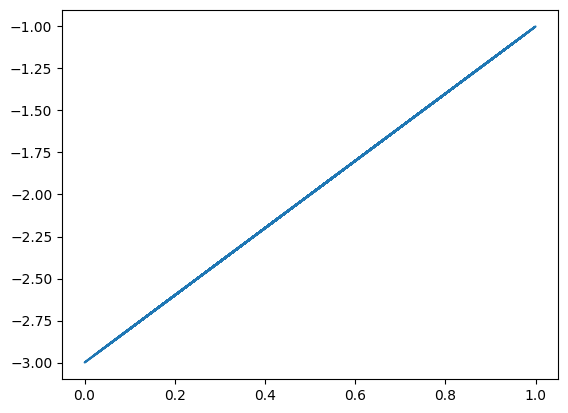

In [541]:
plt.plot(X[:, 1], y)

In [542]:
X = Tensor(np.block([np.ones((10, 1)), np.random.rand(10, 3)]))

In [543]:
X

Tensor([[1.        , 0.76389452, 0.77015411, 0.04546358],
        [1.        , 0.94465577, 0.60602309, 0.90360716],
        [1.        , 0.22655534, 0.75705207, 0.35516002],
        [1.        , 0.50696042, 0.91196028, 0.8031423 ],
        [1.        , 0.47041366, 0.82945478, 0.50390501],
        [1.        , 0.49383967, 0.89260965, 0.68032489],
        [1.        , 0.50675995, 0.18039782, 0.41569873],
        [1.        , 0.26095461, 0.51078437, 0.65412212],
        [1.        , 0.01693343, 0.63969722, 0.33216862],
        [1.        , 0.06092191, 0.4277388 , 0.56497344]])

In [544]:
y = np.dot(X, np.array([[-1, 2, -3, 4]]).T)

In [521]:
model = Sequential([
    Linear(4, 3),
    ReLU(),
    Linear(3, 3),
    ReLU(),
    Linear(3, 1)
])

In [522]:
opt = Optimizer(model.layers(), MSELoss, lr=0.001)

In [528]:
for i in range(100):

    for xi, yi in zip(X, y):

        opt.zero_grad()
        
        y_pred = model(Tensor(xi))
        
        opt.loss.backward(y_pred, Tensor(yi))

        opt.step()

In [529]:
model.layers()[0].weights

Tensor([[ 2.46692311,  2.02911551,  1.88016534],
        [ 3.35543086,  2.27685735,  0.3185621 ],
        [-0.73133725, -0.68309714,  1.53350932],
        [ 4.49330501,  3.0046921 , -0.42640193]])

In [530]:
model.layers()[2].weights

Tensor([[ 0.42058931,  2.29252198,  0.15868685],
        [ 0.53243996,  1.815543  ,  0.26517713],
        [ 0.06831906, -0.57777641,  1.42007395]])

In [531]:
np.dot(np.dot(model.layers()[0].weights, model.layers()[2].weights), model.layers()[4].weights)

Tensor([[-1.],
        [ 2.],
        [-3.],
        [ 4.]])

In [511]:
model(Tensor([0, 1, 0, 0]))

Tensor([[1.83730706]])

In [348]:
t = Tensor(np.block([np.ones((100, 1)), np.linspace(0, 5, 100).reshape(-1, 1)]))

In [44]:
y = model(t)

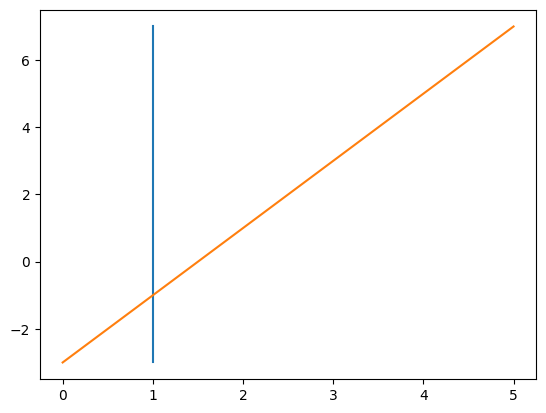

In [45]:
plt.plot(t, y)